In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
from pdfo import *
from casadi import *

In [2]:
n = 500
taux = 5/n
T = linspace(0,5,n)

In [3]:
x = SX.sym('x',n)
gamma = Function ('gamma', [x], [vertcat(0,x[1:]-x[:-1])])

In [4]:
def tracer_orientation (x,y,theta, r, i):
    if i == 1 :
        plt.arrow(x, y, r*cos(theta),r*sin(theta), width = 0.01, color = 'red' , label = "Axe local suivant x")
        plt.arrow(x, y, r*cos(pi/2+theta),r*sin(pi/2+theta), width = 0.01, color = 'yellow' , label = "Axe local suivant y")
        plt.legend()
    else :
        plt.arrow(x, y, r*cos(theta),r*sin(theta), width = 0.01, color = 'red' )
        plt.arrow(x, y, r*cos(pi/2+theta),r*sin(pi/2+theta), width = 0.01, color = 'yellow' )
 

In [5]:
x = SX.sym ('x', n)
xf = SX.sym('xf')

Direct = Function('Direct', [x,xf],[(xf - x[1:])/sqrt((xf - x[:-1])**2 + 10**(-6))])

In [6]:
def MH_DOC(c1,c2,c3,c4,c5,Xi,Xf):
    
    opti = casadi.Opti()   
    ## les positions
    x = opti.variable(n)
    y = opti.variable(n)
    theta = opti.variable(n)

    ## les vitesses 
    v1 = opti.variable(n)        ## vitesse latérale
    v2 = opti.variable(n)        ## vitesse orthogonal
    w = opti.variable(n)         ## vitesse angulaire
    
        ## les vitesses 
    u1 = opti.variable(n)        ## accélération latérale
    u3 = opti.variable(n)        ## accélération orthogonal
    u2 = opti.variable(n)        ## accélération angulaire
    
    
    opti.minimize(  taux*( c1 *dot(u1,u1) + c2*dot(u2,u2 ) + c3*dot(u3 ,u3 ) +  c4 *dot(Direct(y,Xf[1]) , Direct(y,Xf[1]) )  +  c5 *dot (Direct(x,Xf[0])  , Direct(x,Xf[0])) ) )     
    
    opti.subject_to( x[0] == Xi[0] )        
    opti.subject_to( y[0] == Xi[1] )
    opti.subject_to( theta[0] == Xi[2] )
    opti.subject_to( v1[0] == 0 )
    opti.subject_to( w[0]  == 0 )
    opti.subject_to( v2[0] == 0 )
    opti.subject_to( u1[0] == 0 )
    opti.subject_to( u2[0] == 0 )
    opti.subject_to( u3[0] == 0 )

    ## pour les contraintes d'égaliter
    opti.subject_to( x[1:]  == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( y[1:]  == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( theta[1:]  == theta[:n-1] + taux*w[:n-1] )
    opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:] )  )
    opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:] ) )
    opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:] ) )

    ## pour les conditions finales
    opti.subject_to( x[-1]== Xf[0] )
    opti.subject_to( y[-1]== Xf[1] )
    opti.subject_to( theta[-1]== Xf[2] )
    opti.subject_to( v1[-1] == 0 ) 
    opti.subject_to( w[-1]  == 0 ) 
    opti.subject_to( v2[-1] == 0 )
    opti.subject_to( u1[-1] == 0 )
    opti.subject_to( u2[-1] == 0 )
    opti.subject_to( u3[-1] == 0 )


    opti.solver('ipopt', {"expand" : True}, {"acceptable_constr_viol_tol" : 0.0001} )             

    sol = opti.solve()
    

    return sol.value(x),sol.value(y),sol.value(theta),sol.value(v1),sol.value(w),sol.value(v2),sol.value(u1),sol.value(u2),sol.value(u3)

In [7]:
Xi = [1,0.9,pi]
Xf = [0,0,pi/2]

In [8]:
#################################### 1er exemple
c1 = 1.
c2 = 0.
c3 = 0.
c4 = 0.
c5 = 0.
x,y,o,v1,w,v2,u1,u2,u3 = MH_DOC(c1,c2,c3,c4,c5,Xi,Xf)

G = gamma(o)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality co

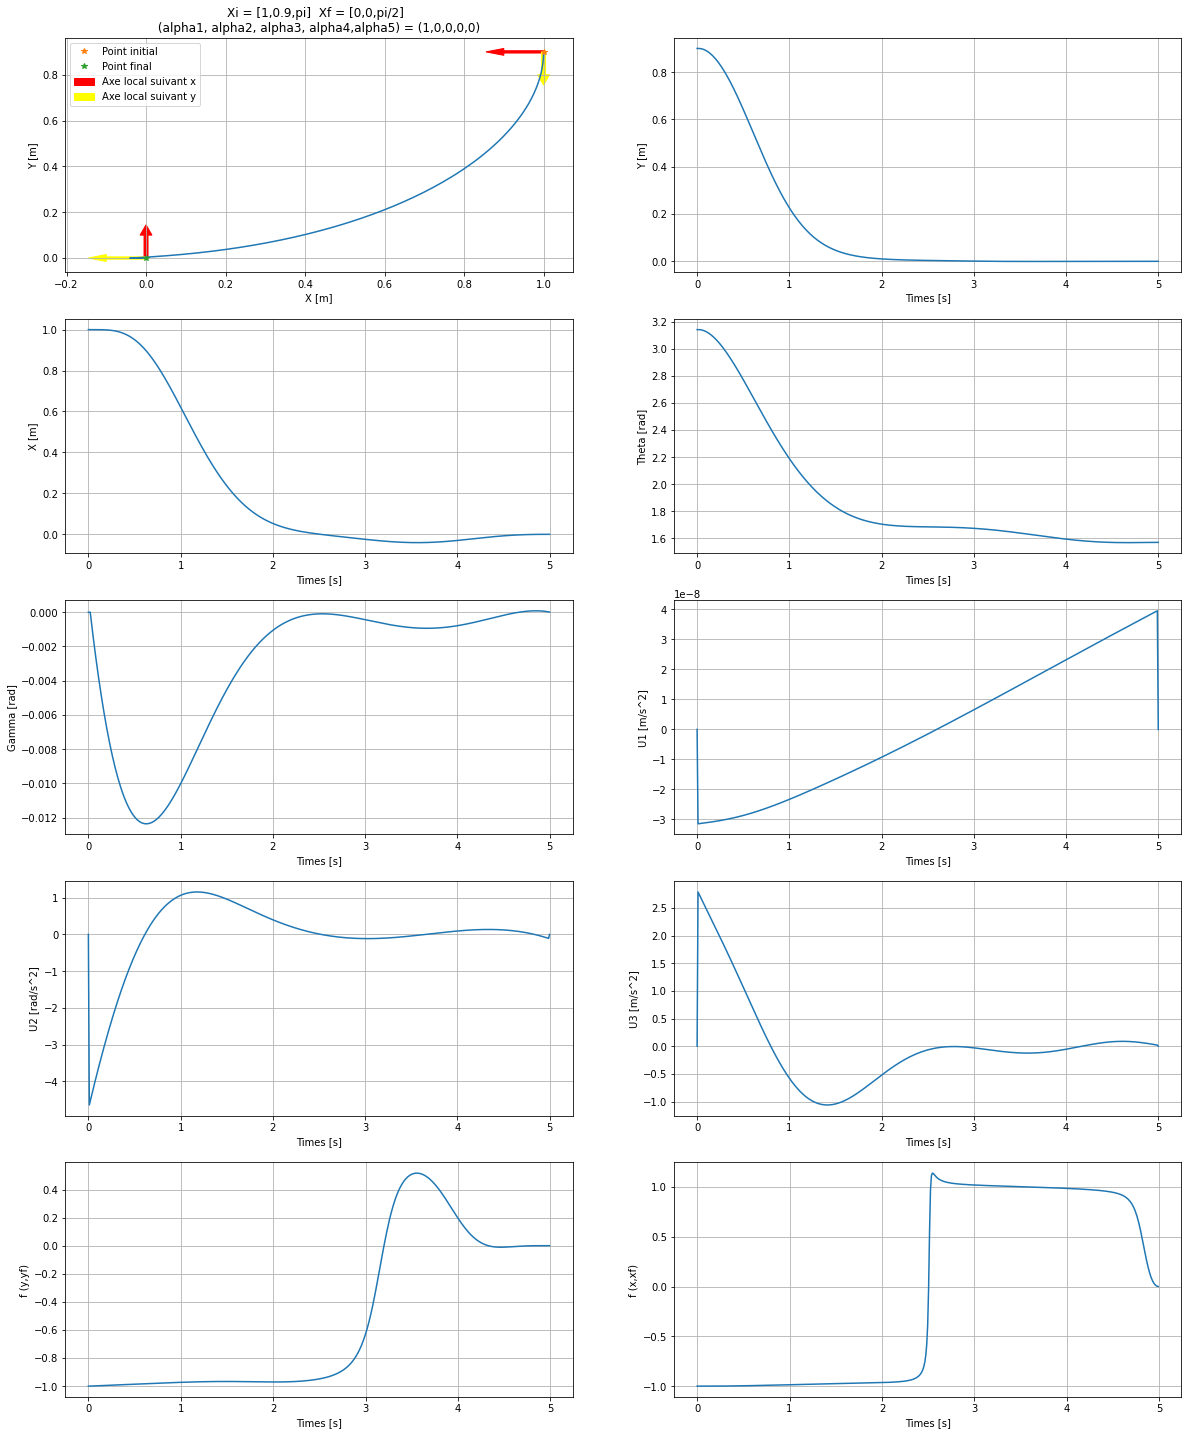

In [9]:
plt.figure(figsize = (20,25))

plt.subplot(5,2,1)
plt.title ("Xi = [1,0.9,pi]  Xf = [0,0,pi/2]  \n (alpha1, alpha2, alpha3, alpha4,alpha5) = (1,0,0,0,0) ")
plt.plot(x,y)
plt.plot(x[0],y[0],'*', label = 'Point initial')
plt.plot(x[-1],y[-1],'*', label = 'Point final')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
tracer_orientation (x[0],y[0],o[0] , 0.1, 1)
tracer_orientation (x[-1],y[-1],o[-1], 0.1, 0)
plt.legend()
plt.grid()

plt.subplot(5,2,2)
plt.plot(T,y)
plt.xlabel("Times [s]")
plt.ylabel("Y [m]")
plt.grid()


plt.subplot(5,2,3)
plt.plot(T,x)
plt.xlabel("Times [s]")
plt.ylabel("X [m]")
plt.grid()

plt.subplot(5,2,4)
plt.plot(T,o)
plt.xlabel("Times [s]")
plt.ylabel("Theta [rad]")
plt.grid()

plt.subplot(5,2,5)
plt.plot(T,G)
plt.xlabel("Times [s]")
plt.ylabel("Gamma [rad]")
plt.grid()

plt.subplot(5,2,6)
plt.plot(T,u1)
plt.xlabel("Times [s]")
plt.ylabel("U1 [m/s^2]")
plt.grid()

plt.subplot(5,2,7)
plt.plot(T,u2)
plt.xlabel("Times [s]")
plt.ylabel("U2 [rad/s^2]")
plt.grid()

plt.subplot(5,2,8)
plt.plot(T,u3)
plt.xlabel("Times [s]")
plt.ylabel("U3 [m/s^2]")
plt.grid()

plt.subplot(5,2,9)
plt.plot(T[:-1],Direct(y,Xf[1]))
plt.xlabel("Times [s]")
plt.ylabel("f (y,yf)")
plt.grid()

plt.subplot(5,2,10)
plt.plot(T[:-1],Direct(x,Xf[0]))
plt.xlabel("Times [s]")
plt.ylabel("f (x,xf)")
plt.grid()

In [10]:
#################################### 2ème exemple
c1 = 0.
c2 = 1.
c3 = 0.
c4 = 0.
c5 = 0.

x,y,o,v1,w,v2,u1,u2,u3 = MH_DOC(c1,c2,c3,c4,c5,Xi,Xf)

G = gamma(o)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

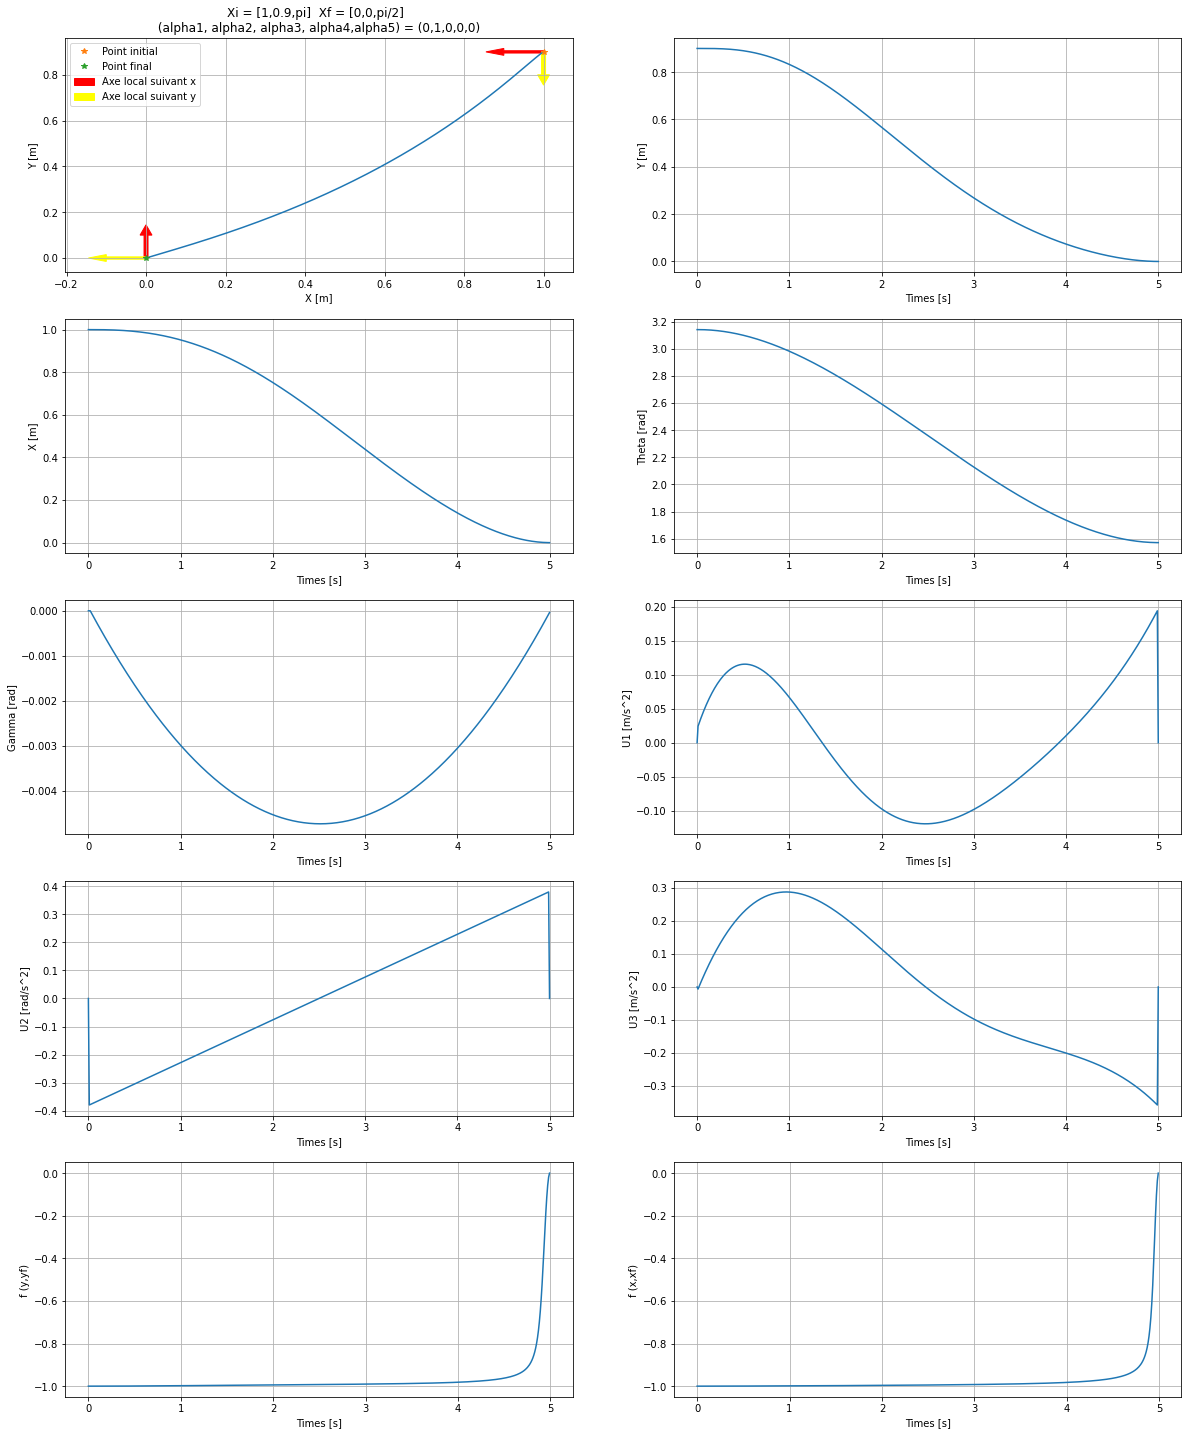

In [11]:
plt.figure(figsize = (20,25))

plt.subplot(5,2,1)
plt.title ("Xi = [1,0.9,pi]  Xf = [0,0,pi/2]  \n (alpha1, alpha2, alpha3, alpha4,alpha5) = (0,1,0,0,0) ")
plt.plot(x,y)
plt.plot(x[0],y[0],'*', label = 'Point initial')
plt.plot(x[-1],y[-1],'*', label = 'Point final')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
tracer_orientation (x[0],y[0],o[0] , 0.1, 1)
tracer_orientation (x[-1],y[-1],o[-1], 0.1, 0)
plt.legend()
plt.grid()

plt.subplot(5,2,2)
plt.plot(T,y)
plt.xlabel("Times [s]")
plt.ylabel("Y [m]")
plt.grid()


plt.subplot(5,2,3)
plt.plot(T,x)
plt.xlabel("Times [s]")
plt.ylabel("X [m]")
plt.grid()

plt.subplot(5,2,4)
plt.plot(T,o)
plt.xlabel("Times [s]")
plt.ylabel("Theta [rad]")
plt.grid()

plt.subplot(5,2,5)
plt.plot(T,G)
plt.xlabel("Times [s]")
plt.ylabel("Gamma [rad]")
plt.grid()

plt.subplot(5,2,6)
plt.plot(T,u1)
plt.xlabel("Times [s]")
plt.ylabel("U1 [m/s^2]")
plt.grid()

plt.subplot(5,2,7)
plt.plot(T,u2)
plt.xlabel("Times [s]")
plt.ylabel("U2 [rad/s^2]")
plt.grid()

plt.subplot(5,2,8)
plt.plot(T,u3)
plt.xlabel("Times [s]")
plt.ylabel("U3 [m/s^2]")
plt.grid()

plt.subplot(5,2,9)
plt.plot(T[:-1],Direct(y,Xf[1]))
plt.xlabel("Times [s]")
plt.ylabel("f (y,yf)")
plt.grid()

plt.subplot(5,2,10)
plt.plot(T[:-1],Direct(x,Xf[0]))
plt.xlabel("Times [s]")
plt.ylabel("f (x,xf)")
plt.grid()

In [12]:
#################################### 3ème exemple
c1 = 0.
c2 = 0.
c3 = 1.
c4 = 0.
c5 = 0.
x,y,o,v1,w,v2,u1,u2,u3 = MH_DOC(c1,c2,c3,c4,c5,Xi,Xf)

G = gamma(o)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

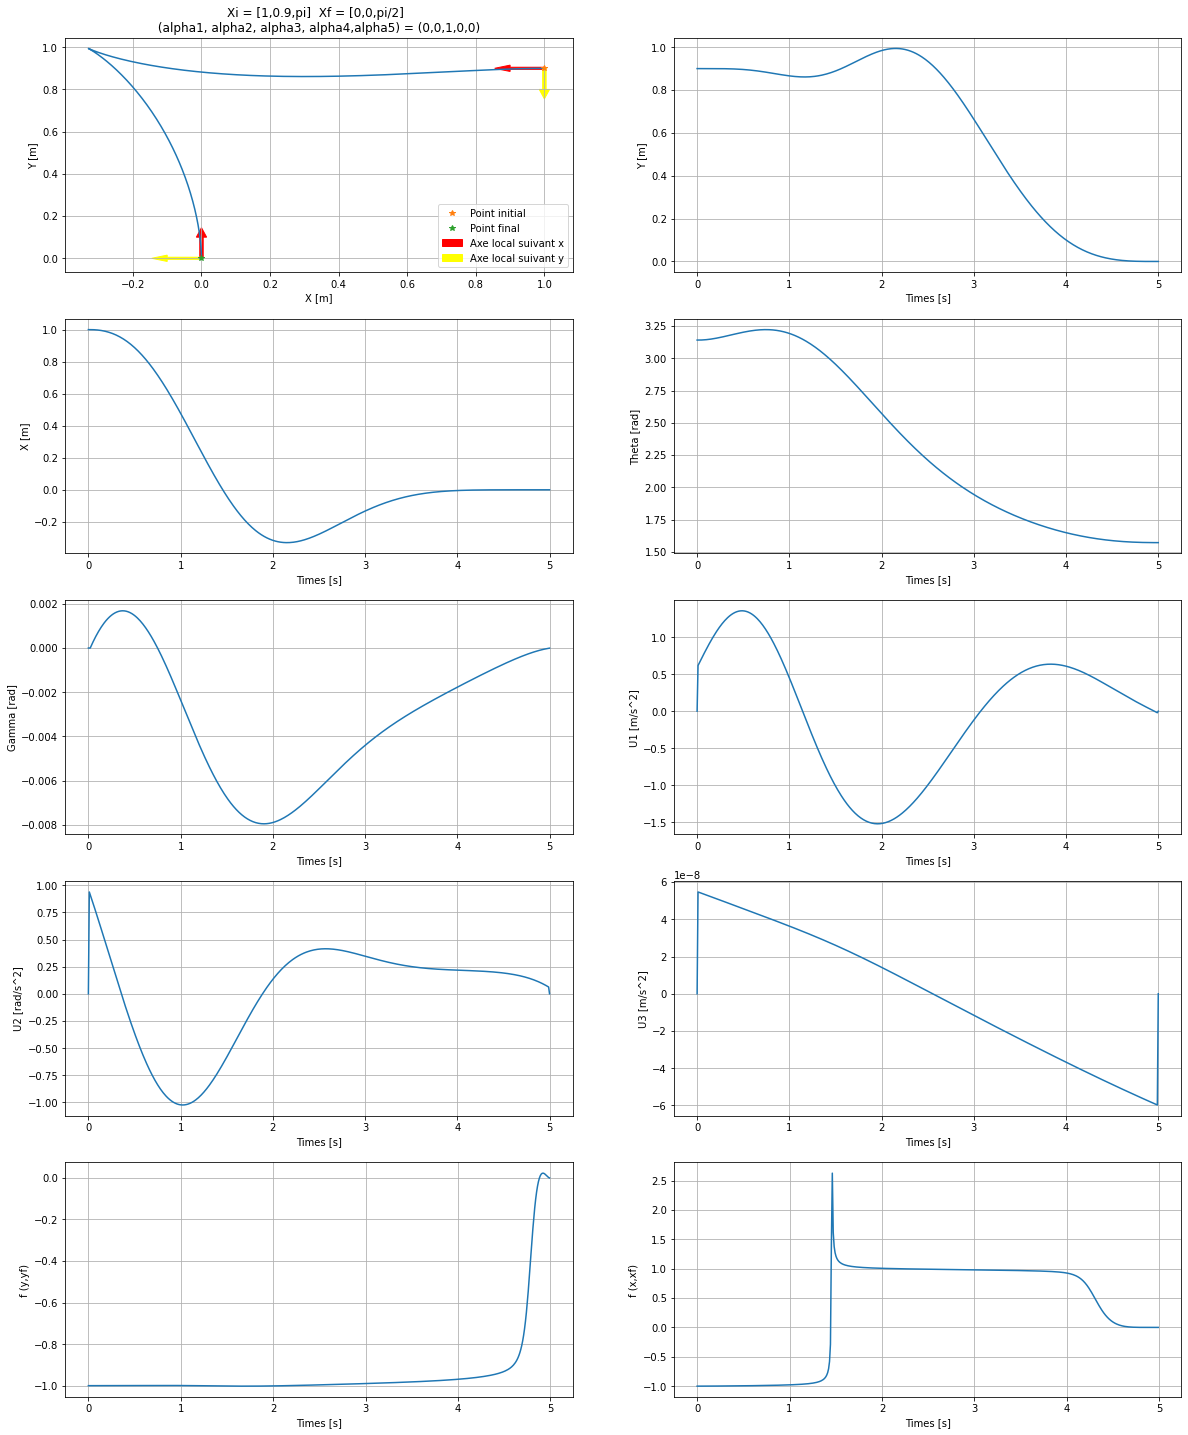

In [13]:
plt.figure(figsize = (20,25))

plt.subplot(5,2,1)
plt.title ("Xi = [1,0.9,pi]  Xf = [0,0,pi/2]  \n (alpha1, alpha2, alpha3, alpha4,alpha5) = (0,0,1,0,0) ")
plt.plot(x,y)
plt.plot(x[0],y[0],'*', label = 'Point initial')
plt.plot(x[-1],y[-1],'*', label = 'Point final')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
tracer_orientation (x[0],y[0],o[0] , 0.1, 1)
tracer_orientation (x[-1],y[-1],o[-1], 0.1, 0)
plt.legend()
plt.grid()

plt.subplot(5,2,2)
plt.plot(T,y)
plt.xlabel("Times [s]")
plt.ylabel("Y [m]")
plt.grid()


plt.subplot(5,2,3)
plt.plot(T,x)
plt.xlabel("Times [s]")
plt.ylabel("X [m]")
plt.grid()

plt.subplot(5,2,4)
plt.plot(T,o)
plt.xlabel("Times [s]")
plt.ylabel("Theta [rad]")
plt.grid()

plt.subplot(5,2,5)
plt.plot(T,G)
plt.xlabel("Times [s]")
plt.ylabel("Gamma [rad]")
plt.grid()

plt.subplot(5,2,6)
plt.plot(T,u1)
plt.xlabel("Times [s]")
plt.ylabel("U1 [m/s^2]")
plt.grid()

plt.subplot(5,2,7)
plt.plot(T,u2)
plt.xlabel("Times [s]")
plt.ylabel("U2 [rad/s^2]")
plt.grid()

plt.subplot(5,2,8)
plt.plot(T,u3)
plt.xlabel("Times [s]")
plt.ylabel("U3 [m/s^2]")
plt.grid()

plt.subplot(5,2,9)
plt.plot(T[:-1],Direct(y,Xf[1]))
plt.xlabel("Times [s]")
plt.ylabel("f (y,yf)")
plt.grid()

plt.subplot(5,2,10)
plt.plot(T[:-1],Direct(x,Xf[0]))
plt.xlabel("Times [s]")
plt.ylabel("f (x,xf)")
plt.grid()

In [14]:
#################################### 4ème exemple
c1 = 0.
c2 = 0.
c3 = 0.
c4 = 1.
c5 = 0.
x,y,o,v1,w,v2,u1,u2,u3 = MH_DOC(c1,c2,c3,c4,c5,Xi,Xf)

G = gamma(o)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2496

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

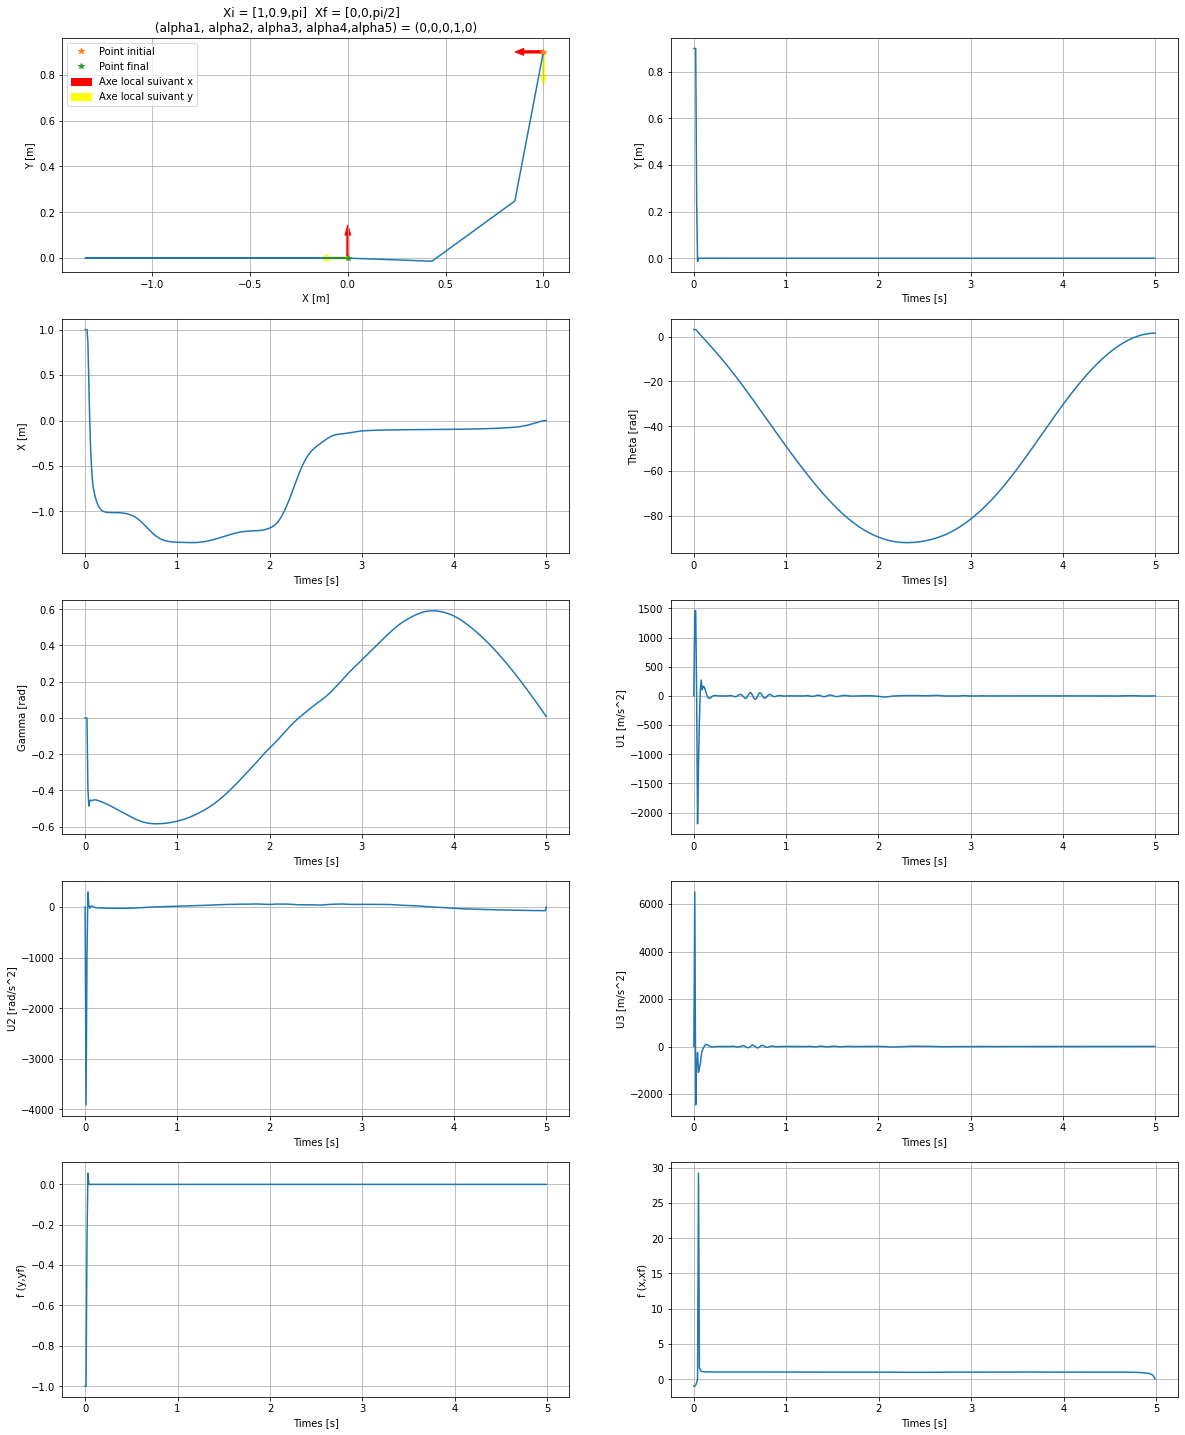

In [15]:
plt.figure(figsize = (20,25))

plt.subplot(5,2,1)
plt.title ("Xi = [1,0.9,pi]  Xf = [0,0,pi/2]  \n (alpha1, alpha2, alpha3, alpha4,alpha5) = (0,0,0,1,0) ")
plt.plot(x,y)
plt.plot(x[0],y[0],'*', label = 'Point initial')
plt.plot(x[-1],y[-1],'*', label = 'Point final')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
tracer_orientation (x[0],y[0],o[0] , 0.1, 1)
tracer_orientation (x[-1],y[-1],o[-1], 0.1, 0)
plt.legend()
plt.grid()

plt.subplot(5,2,2)
plt.plot(T,y)
plt.xlabel("Times [s]")
plt.ylabel("Y [m]")
plt.grid()


plt.subplot(5,2,3)
plt.plot(T,x)
plt.xlabel("Times [s]")
plt.ylabel("X [m]")
plt.grid()

plt.subplot(5,2,4)
plt.plot(T,o)
plt.xlabel("Times [s]")
plt.ylabel("Theta [rad]")
plt.grid()

plt.subplot(5,2,5)
plt.plot(T,G)
plt.xlabel("Times [s]")
plt.ylabel("Gamma [rad]")
plt.grid()

plt.subplot(5,2,6)
plt.plot(T,u1)
plt.xlabel("Times [s]")
plt.ylabel("U1 [m/s^2]")
plt.grid()

plt.subplot(5,2,7)
plt.plot(T,u2)
plt.xlabel("Times [s]")
plt.ylabel("U2 [rad/s^2]")
plt.grid()

plt.subplot(5,2,8)
plt.plot(T,u3)
plt.xlabel("Times [s]")
plt.ylabel("U3 [m/s^2]")
plt.grid()

plt.subplot(5,2,9)
plt.plot(T[:-1],Direct(y,Xf[1]))
plt.xlabel("Times [s]")
plt.ylabel("f (y,yf)")
plt.grid()

plt.subplot(5,2,10)
plt.plot(T[:-1],Direct(x,Xf[0]))
plt.xlabel("Times [s]")
plt.ylabel("f (x,xf)")
plt.grid()

In [16]:
#################################### 5ème exemple
c1 = 0.
c2 = 0.
c3 = 0.
c4 = 0.
c5 = 1.
x,y,o,v1,w,v2,u1,u2,u3 = MH_DOC(c1,c2,c3,c4,c5,Xi,Xf)

G = gamma(o)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2496

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

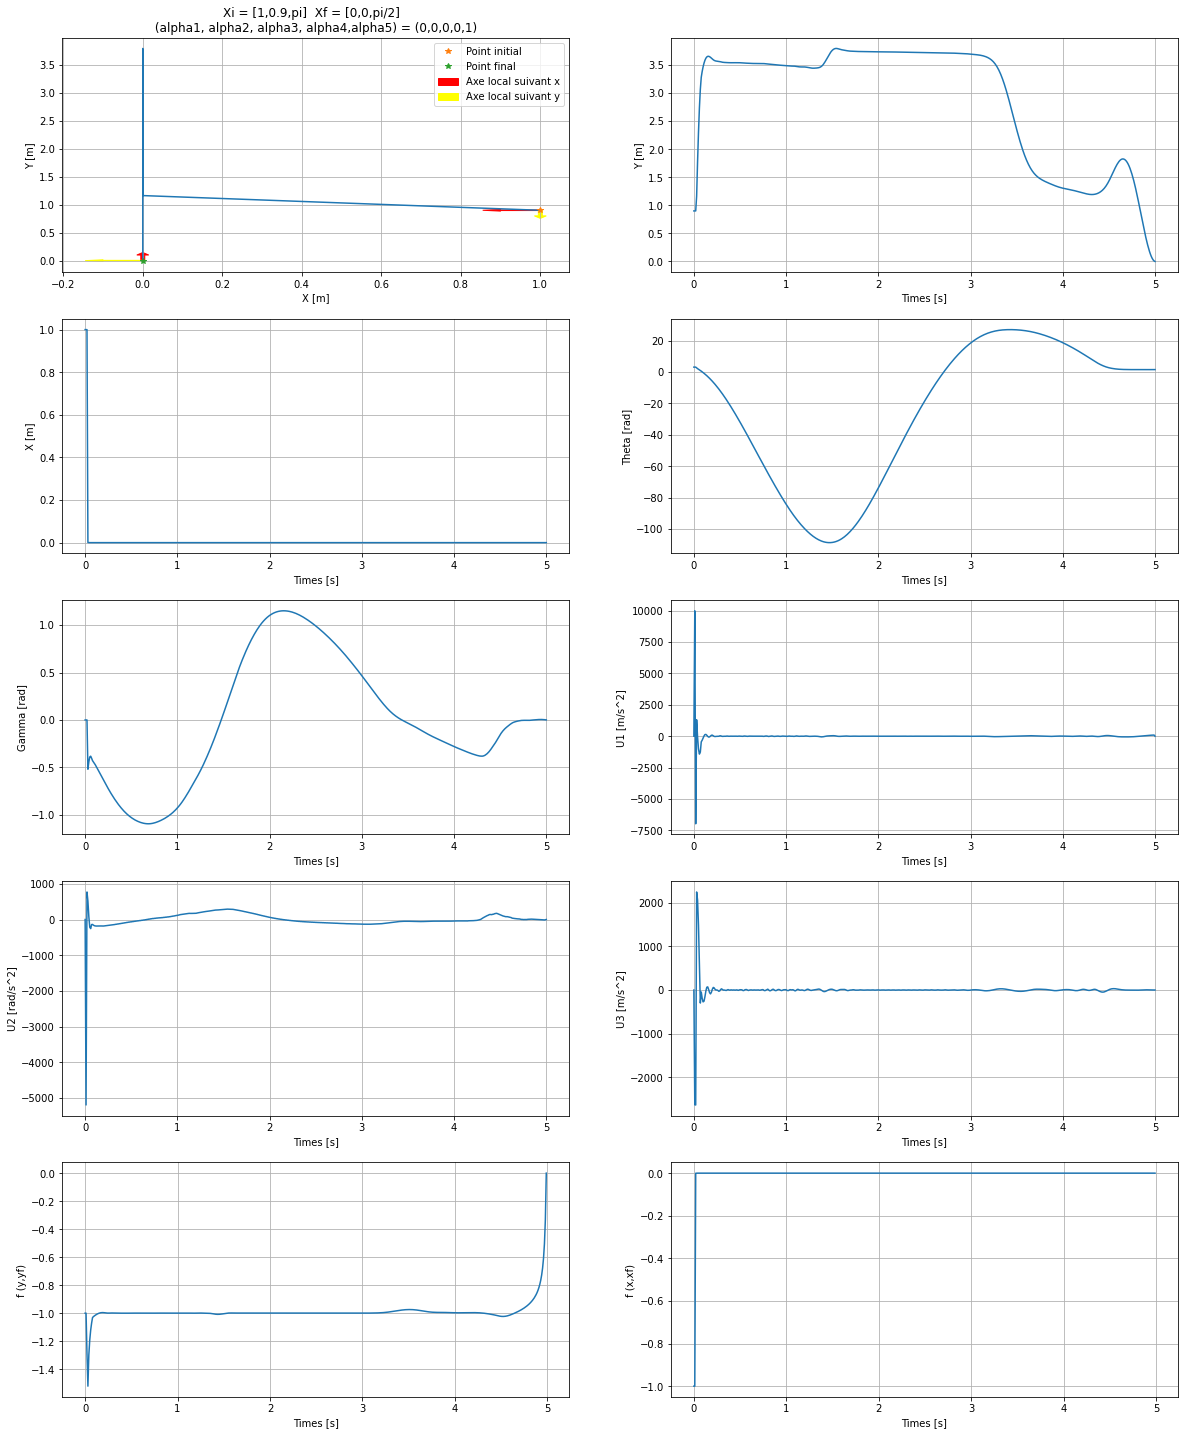

In [17]:
plt.figure(figsize = (20,25))

plt.subplot(5,2,1)
plt.title ("Xi = [1,0.9,pi]  Xf = [0,0,pi/2]  \n (alpha1, alpha2, alpha3, alpha4,alpha5) = (0,0,0,0,1) ")
plt.plot(x,y)
plt.plot(x[0],y[0],'*', label = 'Point initial')
plt.plot(x[-1],y[-1],'*', label = 'Point final')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
tracer_orientation (x[0],y[0],o[0] , 0.1, 1)
tracer_orientation (x[-1],y[-1],o[-1], 0.1, 0)
plt.legend()
plt.grid()

plt.subplot(5,2,2)
plt.plot(T,y)
plt.xlabel("Times [s]")
plt.ylabel("Y [m]")
plt.grid()


plt.subplot(5,2,3)
plt.plot(T,x)
plt.xlabel("Times [s]")
plt.ylabel("X [m]")
plt.grid()

plt.subplot(5,2,4)
plt.plot(T,o)
plt.xlabel("Times [s]")
plt.ylabel("Theta [rad]")
plt.grid()

plt.subplot(5,2,5)
plt.plot(T,G)
plt.xlabel("Times [s]")
plt.ylabel("Gamma [rad]")
plt.grid()

plt.subplot(5,2,6)
plt.plot(T,u1)
plt.xlabel("Times [s]")
plt.ylabel("U1 [m/s^2]")
plt.grid()

plt.subplot(5,2,7)
plt.plot(T,u2)
plt.xlabel("Times [s]")
plt.ylabel("U2 [rad/s^2]")
plt.grid()

plt.subplot(5,2,8)
plt.plot(T,u3)
plt.xlabel("Times [s]")
plt.ylabel("U3 [m/s^2]")
plt.grid()

plt.subplot(5,2,9)
plt.plot(T[:-1],Direct(y,Xf[1]))
plt.xlabel("Times [s]")
plt.ylabel("f (y,yf)")
plt.grid()

plt.subplot(5,2,10)
plt.plot(T[:-1],Direct(x,Xf[0]))
plt.xlabel("Times [s]")
plt.ylabel("f (x,xf)")
plt.grid()

In [18]:
#################################### 6ème exemple
c1 = 0.2
c2 = 0.2
c3 = 0.2
c4 = 0.2
c5 = 0.2
x,y,o,v1,w,v2,u1,u2,u3 = MH_DOC(c1,c2,c3,c4,c5,Xi,Xf)

G = gamma(o)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4995

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

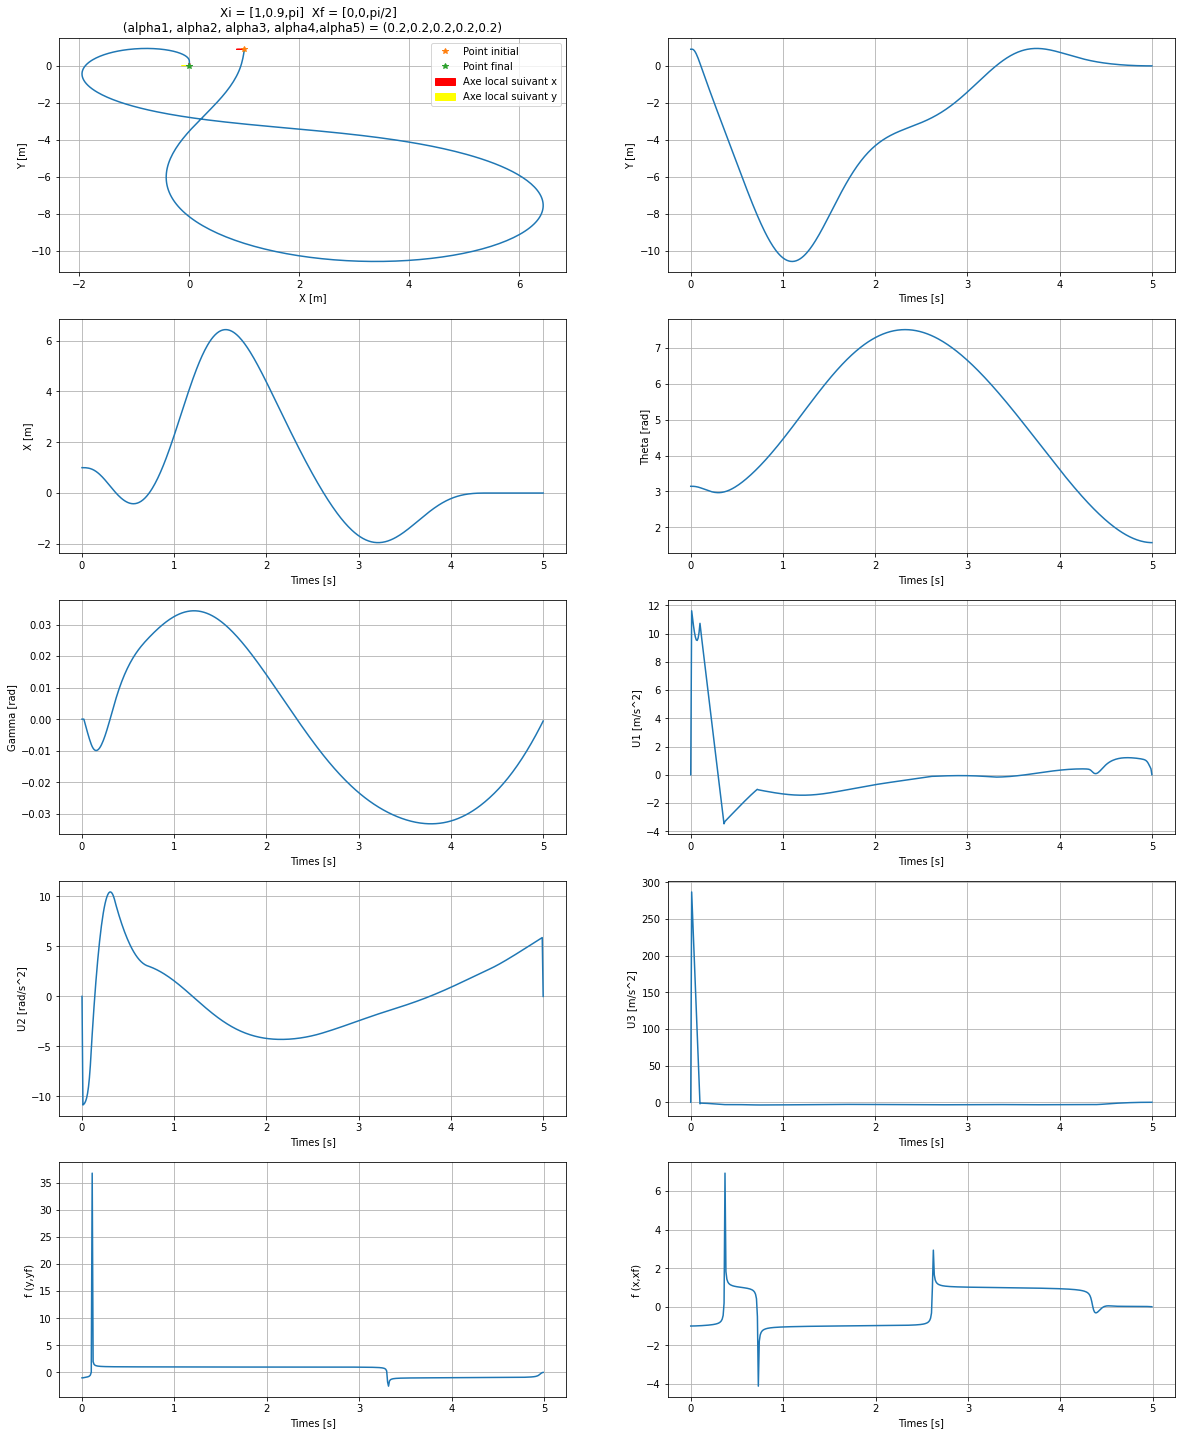

In [19]:
plt.figure(figsize = (20,25))

plt.subplot(5,2,1)
plt.title ("Xi = [1,0.9,pi]  Xf = [0,0,pi/2]  \n (alpha1, alpha2, alpha3, alpha4,alpha5) = (0.2,0.2,0.2,0.2,0.2) ")
plt.plot(x,y)
plt.plot(x[0],y[0],'*', label = 'Point initial')
plt.plot(x[-1],y[-1],'*', label = 'Point final')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
tracer_orientation (x[0],y[0],o[0] , 0.1, 1)
tracer_orientation (x[-1],y[-1],o[-1], 0.1, 0)
plt.legend()
plt.grid()

plt.subplot(5,2,2)
plt.plot(T,y)
plt.xlabel("Times [s]")
plt.ylabel("Y [m]")
plt.grid()


plt.subplot(5,2,3)
plt.plot(T,x)
plt.xlabel("Times [s]")
plt.ylabel("X [m]")
plt.grid()

plt.subplot(5,2,4)
plt.plot(T,o)
plt.xlabel("Times [s]")
plt.ylabel("Theta [rad]")
plt.grid()

plt.subplot(5,2,5)
plt.plot(T,G)
plt.xlabel("Times [s]")
plt.ylabel("Gamma [rad]")
plt.grid()

plt.subplot(5,2,6)
plt.plot(T,u1)
plt.xlabel("Times [s]")
plt.ylabel("U1 [m/s^2]")
plt.grid()

plt.subplot(5,2,7)
plt.plot(T,u2)
plt.xlabel("Times [s]")
plt.ylabel("U2 [rad/s^2]")
plt.grid()

plt.subplot(5,2,8)
plt.plot(T,u3)
plt.xlabel("Times [s]")
plt.ylabel("U3 [m/s^2]")
plt.grid()

plt.subplot(5,2,9)
plt.plot(T[:-1],Direct(y,Xf[1]))
plt.xlabel("Times [s]")
plt.ylabel("f (y,yf)")
plt.grid()

plt.subplot(5,2,10)
plt.plot(T[:-1],Direct(x,Xf[0]))
plt.xlabel("Times [s]")
plt.ylabel("f (x,xf)")
plt.grid()